<a href="https://colab.research.google.com/github/ErikVegaC/Proyecto_Modulo_1_Portafolio_de_Inversion/blob/main/ProyectoModulo1_LopezJ_VegaE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INSTITUTO DE ESTUDIOS SUPERIORES DE OCCIDENTE #

## 2.1 Construcción de un portafolio de inversión con programación lineal ##

*Profesor Gabriel Alejandro Morales*

Alumnos:
* Juan Ramón López Rocha
* Erik Vega Sánchez

*3 de Octubre*

## 2.2 Objetivos

### 1.1 Objetivo general

* Vamos a maximizar los rendimientos de un portafolio de inversión encontrando las ponderaciones adecuadas a invertir para cada uno de los activos

### 1.2 Objetivos específicos

* Seleccionar los activos a invertir y calcular el rendimiento anual que han tenido en los últimos 3 años
* Plantear la función a optimizar que maximice el rendimiento
* Evaluar las necesidades del portafolio para elaborar las restricciones con las que haremos el modelo
* Obtener los montos necesarios a invertir para cada uno de los activos

## 2.3 Modelo del programa

Para generar el modelo que maximice los rendimientos se utilizarán los datos de los precios del cierre del día desde el 1 de enero del 2021 de los activos sacados de Yahoo finance.

Las acciones con las que se trabajará en el portafolio son:
* CMG: Chipotle Mexican Grill, es una cadena de restaurantes especializada en comida rápida de estilo mexicano, conocida por su enfoque en ingredientes frescos y sostenibles. Tiene una fuerte presencia en EE.UU. y continúa expandiéndose a nivel internacional.
* COST: Costco, es una de las cadenas de almacenes más grandes del mundo, que opera bajo un modelo de membresía, vendiendo productos al por mayor. Es conocida por sus precios competitivos y su sólido crecimiento en ventas.
* NVDA: Nvidia, es líder en el desarrollo de unidades de procesamiento gráfico (GPU) utilizadas en videojuegos, inteligencia artificial y procesamiento de datos. Su tecnología es fundamental en industrias emergentes como el metaverso y los vehículos autónomos.
* OXY: Occidental Petroleum, es una empresa internacional de exploración y producción de petróleo y gas, con operaciones en EE.UU., Medio Oriente y América Latina. También invierte en tecnología de captura de carbono para reducir su huella ambiental.
* NVO: Novo Nordisk, es una compañía farmacéutica danesa especializada en tratamientos para la diabetes y otros trastornos metabólicos. Es líder mundial en la producción de insulina y otras terapias innovadoras para el control de la glucosa.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [ ]:
def get_adj_closes(tickers, start_date=None, end_date=None):
    data = yf.download(tickers, start=start_date, end=end_date)

    closes = data['Adj Close']
    return closes

tickers = ['CMG', 'COST', 'NVDA','OXY','NVO']
start_date = '2021-01-01'
closes = get_adj_closes(tickers=tickers, start_date=start_date)
closes

[*********************100%***********************]  5 of 5 completed


Ticker,CMG,COST,NVDA,NVO,OXY
Date,,,,,
2021-01-04 00:00:00+00:00,26.382401,362.045807,13.081202,33.694305,16.881639
2021-01-05 00:00:00+00:00,27.102200,357.845825,13.371737,33.382977,18.584316
2021-01-06 00:00:00+00:00,26.868200,352.398224,12.583434,32.515026,19.348581
2021-01-07 00:00:00+00:00,27.362801,350.398346,13.311136,33.062210,19.900019
2021-01-08 00:00:00+00:00,28.048800,352.322083,13.244050,33.142410,19.425978
...,...,...,...,...,...
2024-09-30 00:00:00+00:00,57.619999,886.520020,121.440002,119.070000,51.540001
2024-10-01 00:00:00+00:00,57.169998,877.380005,117.000000,118.010002,53.250000
2024-10-02 00:00:00+00:00,57.680000,878.530029,118.849998,116.480003,53.439999


In [ ]:
ret = closes.pct_change().dropna()
ret.head()

Ticker,CMG,COST,NVDA,NVO,OXY
Date,,,,,
2021-01-05 00:00:00+00:00,0.027283,-0.011601,0.022210,-0.009240,0.100860
2021-01-06 00:00:00+00:00,-0.008634,-0.015223,-0.058953,-0.026000,0.041124
2021-01-07 00:00:00+00:00,0.018408,-0.005675,0.057830,0.016829,0.028500
2021-01-08 00:00:00+00:00,0.025070,0.005490,-0.005040,0.002426,-0.023821
2021-01-11 00:00:00+00:00,0.000128,-0.016030,0.025967,0.002277,0.000000


In [ ]:
summary_annual = pd.DataFrame({
    "media": ret.mean() * 252,
}).T
summary_annual

Ticker,CMG,COST,NVDA,NVO,OXY
media,0.255238,0.264823,0.745369,0.372662,0.417461


### Función a optimizar

Dado los rendimientos anuales de cada uno de los activos vamos a maximizar el portafolio con esta función:
$$ R_{max} = 0.2552CMG + 0.2648COST + 0.7453NVDA + 0.3726NVO + 0.4174OXY $$

Cada uno de los rendimientos se multiplicará por la cantidad de dinero que invertiremos en los activos para juntos se maximice el rendimiento del portafolio, el tamaño del portafolio será de $1,000,000


Las variables que podemos controlar son las cantidades a invertir por cada activo por lo que generaremos restricciones para invertir cierta cantidad mínima en cada uno, por lo que podemos resolverlo con programación lineal. Pondremos mínimo el 10% para cada activo y como máximo 50% solo a Nvidia por ser la acción con mayor riesgo.

Restricciones:
$$ CMG + COST + NVDA + NVO + OXY = 1000000 $$
$$ CMG \geq 100000 $$
$$ COST \geq 100000 $$
$$ NVDA \geq 100000 $$
$$ NVDA \leq 500000 $$
$$ NVO \geq 100000 $$
$$ OXY \geq 100000 $$

La limitación de nuestro modelo es que solo se busca maximizar el modelo, no tomamos en cuenta el riesgo no sistemático, además de las perspectivas macroeconómicas del país de residencia de los activos que es Estados Unidos.
Seleccionamos estas empresas por un análisis fundamental basado en sus reportes financieros y con el crecimiento constante de EPS y ventas en cada trimestre, además de la correlación que los acitvos tienen entre sí.

Las restricciones se hicieron de forma que el sector con mayor potencial de crecimento en los próximos años tenga el mayor peso pero no más del 50% del portafolio que implicaría no estar diversificado, los otros sectores con un mínimo de 10% para que tengan una ponderación de minima importante y diversifiquen el portafolio total.

### Matriz de correlación con mapa de calor

Matriz de correlación:
Ticker       CMG      COST      NVDA       NVO       OXY
Ticker                                                  
CMG     1.000000  0.407217  0.489653  0.217358  0.126631
COST    0.407217  1.000000  0.443188  0.247590  0.100320
NVDA    0.489653  0.443188  1.000000  0.267567  0.146207
NVO     0.217358  0.247590  0.267567  1.000000  0.024830
OXY     0.126631  0.100320  0.146207  0.024830  1.000000


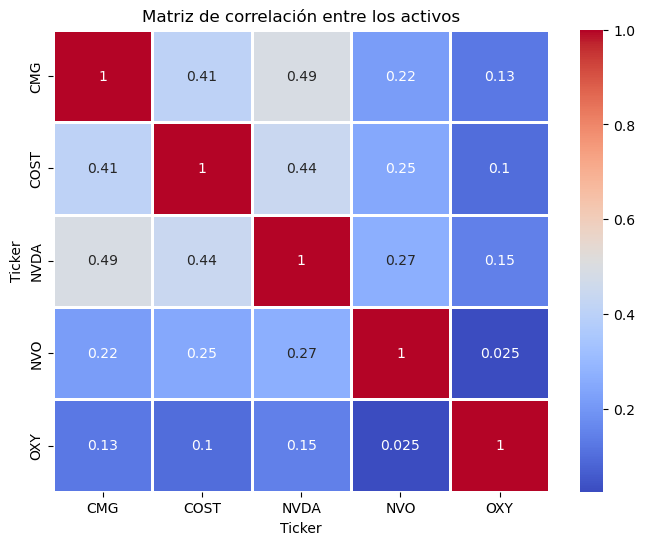

In [ ]:
import seaborn as sns
returns = closes.pct_change().dropna()

correlation_matrix = returns.corr()
print("Matriz de correlación:")
print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.8)
plt.title("Matriz de correlación entre los activos")
plt.show()

Sectores de los activos:
* CMG (Chipotle Mexican Grill): Consumo Discrecional en el sector de alimentos y restaurantes.
* COST (Costco Wholesale): Consumo Defensivo en el sector de venta minorista y almacenes.
* NVDA (NVIDIA Corporation): Tecnología en el sector de semiconductores y tecnología, con foco en inteligencia artificial y gráficos.
* NVO (Novo Nordisk): Salud en el sector farmacéutico, especializado en tratamientos para la diabetes y otras enfermedades crónicas.
* OXY (Occidental Petroleum): Energía en el sector energético, específicamente petróleo y gas.

La cartera que hemos creado abarca una buena diversidad de sectores: consumo discrecional, consumo defensivo, tecnología, salud y energía. Esta diversidad sectorial es importante porque diferentes sectores tienden a comportarse de manera distinta en distintas fases del ciclo económico. Por ejemplo, el sector de tecnología (NVDA) puede ser más volátil, mientras que los sectores de salud (NVO) y consumo defensivo (COST) tienden a ser más estables en tiempos de crisis.

Para hace énfasis en la correlación y diversificación, el análisis entre estos activos nos da una idea de qué tan alineados están los movimientos de precios entre ellos.

Para entender las correlaciones bajas o negativas sugieren que los activos tienden a moverse en direcciones opuestas o sin una relación fuerte, lo que es deseable en una cartera diversificada, ya que reduce el riesgo total. Por ejemplo, si uno de los activos del sector energético (OXY) cae por una crisis en los precios del petróleo, los otros activos en tecnología, salud o consumo pueden comportarse de manera diferente, protegiendo la cartera.
Correlaciones altas sugieren que los activos tienden a moverse en la misma dirección, lo que puede aumentar el riesgo en períodos de volatilidad si todos caen al mismo tiempo.

Todos nuestros activos tienen una correlación menor a 0.5, lo que significa que estamos diversifacados de buena manera, y la mayoría son menores a 0.3 lo que es aún mejor para la diversificación

## 2.4 Solución del problema de optimización

In [ ]:
import numpy as np
import scipy.optimize as opt
R=np.array([-0.255238,
            -0.264823,
            -0.745369,
            -0.372662,
            -0.417461])

Aub=np.array([
    [-1, 0, 0, 0, 0],
    [0, -1, 0, 0, 0],
    [0, 0, -1, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 0, -1, 0],
    [0, 0, 0, 0, -1]
])

bub=np.array([-100000,
              -100000,
              -100000,
              500000,
              -100000,
              -100000,])

A_eq=np.array([
    [1, 1, 1, 1, 1]
])

beq = np.array([1000000])

sol = opt.linprog (R, Aub, bub, A_eq, beq)
sol

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: -545449.0
              x: [ 1.000e+05  1.000e+05  5.000e+05  1.000e+05  2.000e+05]
            nit: 0
          lower:  residual: [ 1.000e+05  1.000e+05  5.000e+05  1.000e+05
                              2.000e+05]
                 marginals: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00
                              0.000e+00]
          upper:  residual: [       inf        inf        inf        inf
                                    inf]
                 marginals: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00
                              0.000e+00]
          eqlin:  residual: [ 0.000e+00]
                 marginals: [-4.175e-01]
        ineqlin:  residual: [ 0.000e+00  0.000e+00  4.000e+05  0.000e+00
                              0.000e+00  1.000e+05]
                 marginals: [-1.622e-01 -1.526e-01 -0.000e+00 -3.279e-01
                      

Como resultado de nuestro modelo obtuvimos:

* 10% en CMG que serán $100,000
   
* 10% en COST que serán $100,000
  
* 50% en NVDA que serán $500,000
  
* 10% en NVO que serán $200,000
  
* 20% en OXY que serán $100,000

Se condujo a una solución factible que demuestra que nuestro modelo es congruente y busca el maximiento rendimiento esperado con el portafolio armado

## 2.5 Visualización de la solución del problema

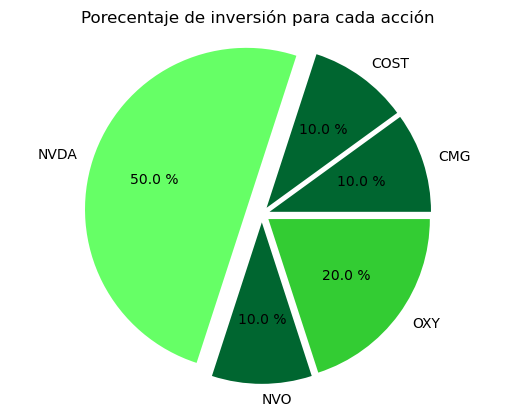

In [ ]:
import matplotlib.pyplot as plt
plt.title('Porecentaje de inversión para cada acción')
activos = [100000,100000,500000,100000,200000]
nombres = ["CMG","COST","NVDA","NVO","OXY"]
colores = ["#006630", "#006630", "#66ff66", "#006630", "#33cc33"]
desfase = (0.05, 0.05, 0.1, 0.05, 0.05)
plt.pie(activos, labels=nombres, autopct="%0.1f %%", colors=colores, explode=desfase)
plt.axis("equal")
plt.show()

## 2.6 Conclusiones

Finalmente, se puede concluir que se logró encontrar el portafolio de inversión que maximiza las ganancias de la cartera propuesta utilizando la función de costo, la cual fue planteada con los rendimientos anuales de los activos Chipotle Mexican Grill (CMG), Costco Wholesale Corporation (COST), NVIDIA Corporation (NVDA), Novo Nordisk (NVO), y Occidental Petroleum Corporation (OXY).

Con un capital disponible de 1,000,000, del cual se colocó en el activo de mayor peso un total del 50%, y al menos el 10% en cada uno de los demás activos, la optimización arrojó que se debe invertir 500,000 en NVDA; 100,000 en CMG, COST y NVO y 200,000 en OXY para obtener un rendimiento máximo en la cartera de inversión. Este resultado es coherente con las expectativas planteadas para este problema.

### Backtesting

El backtesting es una técnica fundamental en las finanzas que permite evaluar el rendimiento histórico de una estrategia de inversión simulando su comportamiento en el pasado.
Como vemos en las gráficas el resultado de nuestra estrategia comparado al de solo el rendimiento del benchmark que en este caso sería el S&P 500

[*********************100%***********************]  6 of 6 completed


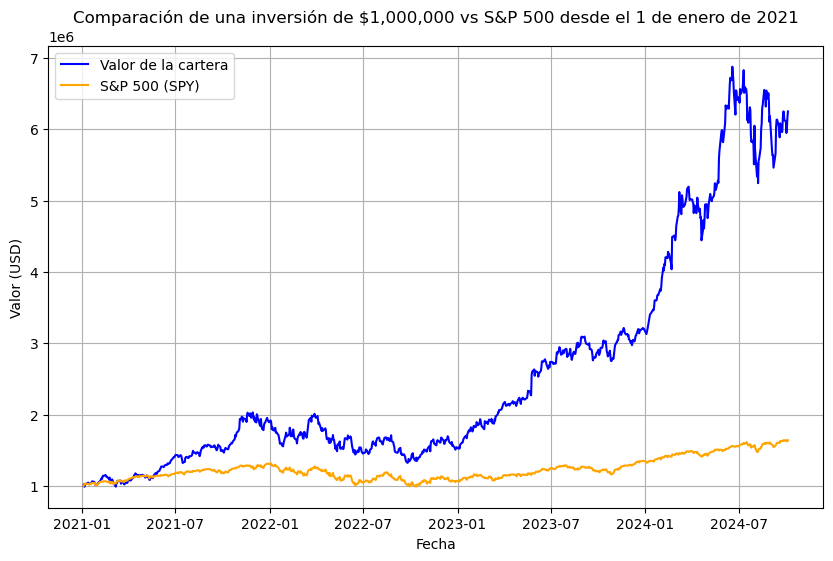

Valor final del S&P500: $1,639,560.70
Valor final del portafolio: $6,237,267.22


In [ ]:
tickers = ['CMG', 'COST', 'NVDA', 'NVO', 'OXY', 'SPY']
start_date = '2021-01-01'
data = yf.download(tickers, start=start_date)
closes = data['Adj Close']

ponderaciones = [0.1, 0.1, 0.5, 0.2, 0.1, 0]
inversion_inicial = 1000000
closes_normalized = closes / closes.iloc[0]

valores_diarios_cartera = closes_normalized.mul(ponderaciones, axis=1).sum(axis=1) * inversion_inicial

sp500_normalized = closes['SPY'] / closes['SPY'].iloc[0] * inversion_inicial

plt.figure(figsize=(10,6))
plt.plot(valores_diarios_cartera, label='Valor de la cartera', color='blue')
plt.plot(sp500_normalized, label='S&P 500 (SPY)', color='orange')
plt.title('Comparación de una inversión de $1,000,000 vs S&P 500 desde el 1 de enero de 2021')
plt.xlabel('Fecha')
plt.ylabel('Valor (USD)')
plt.grid()
plt.legend()
plt.show()
print(f"Valor final del S&P500: ${spy_value.iloc[-1]:,.2f}")
print(f"Valor final del portafolio: ${portfolio_value.iloc[-1]:,.2f}")

El backtesting ha demostrado que nuestro portafolio de inversión habría funcionado bien, señalando que una concentración tan grande en un solo activo puede ser riesgosa tomando el potencial de NVIDIA decidimos optar por seguir estando con mayor peso debido a sus expectativas de crecimiento. Además, si el S&P 500 ha tenido un rendimiento cercano o mejor que tu estrategia, podría ser preferible optar por una inversión pasiva en el índice, ya que reduce el riesgo y el esfuerzo de selección de activos. Aunque los rendmientos no son comporables pues lo superamos con una diferencia muy grande, eso justifica las decisiones de selección y ponderación de activos.

## 2.7 Referencias
Chipotle Mexican Grill. (n.d.). Company overview. Chipotle Mexican Grill, Inc. Retrieved from https://www.chipotle.com

Costco Wholesale Corporation. (n.d.). Company profile. Costco Wholesale. Retrieved from https://www.costco.com

Nvidia Corporation. (n.d.). About us. Nvidia Corporation. Retrieved from https://www.nvidia.com

Occidental Petroleum Corporation. (n.d.). About us. Occidental Petroleum. Retrieved from https://www.oxy.com

Novo Nordisk A/S. (n.d.). Company profile. Novo Nordisk. Retrieved from https://www.novonordisk.com